In [3]:
ngram_range = [1,2]
n_terms = 4000
n_topics = 10
# n_topics = 20
max_iter = 20
n_top_terms = 9

In [4]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation as LDA
import plotly_express as px

In [5]:
import warnings
warnings.filterwarnings('ignore')

In [6]:
TOKENS = pd.read_csv('TOKENS.csv')
TOKENS

,company_id,link_num,sent_num,token_num,pos_tuple,pos,token_str,term_str
0,1,0,0,0,"('Manufacturer', 'NNP')",NNP,Manufacturer,manufacturer
1,1,0,0,3,"('Hardware', 'NNP')",NNP,Hardware,hardware
2,1,0,0,4,"('Custom', 'NNP')",NNP,Custom,custom
3,1,0,0,5,"('Metal', 'NNP')",NNP,Metal,metal
4,1,0,0,6,"('Crafters', 'NNP')",NNP,Crafters,crafters
...,...,...,...,...,...,...,...,...
144146,1222,2,4,0,"('Success', 'NN')",NN,Success,success
144147,1222,2,5,1,"('message', 'NN')",NN,message,message
144148,1222,2,6,3,"('PentaCast', 'NNP')",NNP,PentaCast,pentacast
144149,1222,2,6,4,"('Inc', 'NNP')",NNP,Inc,inc


In [7]:
BAG = ['company_id', 'link_num']

In [8]:
DOCS = TOKENS[TOKENS.pos.str.match(r'^NNS?$')]\
    .groupby(BAG).term_str\
    .apply(lambda x: ' '.join(x))\
    .to_frame()\
    .rename(columns={'term_str':'doc_str'})
DOCS.sample(5)

,,doc_str
company_id,link_num,
913,0,foundries quality castings
56,5,mold sand casting capabilities molding departm...
139,0,capabilities capacity pounds shift variety qua...
1056,1,years bridges steel deck bridges forestry indu...
837,2,manufacturing services products provider years...


In [9]:
count_engine = CountVectorizer(max_features=n_terms, ngram_range=ngram_range, stop_words='english')
count_model = count_engine.fit_transform(DOCS.doc_str)
TERMS = count_engine.get_feature_names()

In [10]:
VOCAB = pd.DataFrame(index=TERMS)
VOCAB.index.name = 'term_str'

In [11]:
DTM = pd.DataFrame(count_model.toarray(), index=DOCS.index, columns=TERMS)

In [12]:
VOCAB['doc_count'] = DTM.astype('bool').astype('int').sum()
DOCS['term_count'] = DTM.sum(1)

In [13]:
DOCS.term_count.describe()

count    2110.000000
mean       39.860664
std        51.538378
min         0.000000
25%         6.000000
50%        24.000000
75%        52.000000
max       428.000000
Name: term_count, dtype: float64

In [14]:
lda_engine = LDA(n_components=n_topics, max_iter=max_iter, learning_offset=50., random_state=0)

In [15]:
TNAMES = [f"T{str(x).zfill(len(str(n_topics)))}" for x in range(n_topics)]

In [16]:
lda_model = lda_engine.fit_transform(count_model)

In [17]:
THETA = pd.DataFrame(lda_model, index=DOCS.index)
THETA.columns.name = 'topic_id'
THETA.columns = TNAMES

In [18]:
colors = "YlGnBu"
THETA.sample(20).style.background_gradient(cmap=colors, axis=None)

### Table of document and topic concentrations.

In [33]:
DOC_TOPIC = THETA.reset_index().groupby('company_id')['T00', 'T01', 'T02', 'T03', 'T04', 'T05', 'T06', 'T07', 'T08', 'T09'].mean()
DOC_TOPIC.to_csv("DOC_TOPIC.csv")
DOC_TOPIC

,T00,T01,T02,T03,T04,T05,T06,T07,T08,T09
company_id,,,,,,,,,,
1,0.038951,0.127984,0.008986,0.088465,0.040639,0.033258,0.042321,0.599900,0.010511,0.008985
5,0.013933,0.109166,0.276497,0.013931,0.013933,0.244703,0.013932,0.034734,0.122319,0.156853
10,0.189447,0.010552,0.089579,0.069975,0.010551,0.406261,0.010552,0.107695,0.057508,0.047880
12,0.016062,0.016062,0.291926,0.018838,0.016064,0.505372,0.016062,0.016062,0.087488,0.016062
14,0.031840,0.004653,0.004655,0.042366,0.004654,0.199572,0.004653,0.075418,0.004654,0.627534
...,...,...,...,...,...,...,...,...,...,...
1211,0.003245,0.003245,0.003245,0.003245,0.032281,0.844467,0.028983,0.013535,0.050886,0.016868
1212,0.302792,0.038751,0.038750,0.038750,0.074706,0.351248,0.038750,0.038751,0.038752,0.038750
1216,0.055112,0.005287,0.015538,0.002098,0.571800,0.190707,0.011205,0.002098,0.084742,0.061413


In [22]:
PHI = pd.DataFrame(lda_engine.components_, columns=TERMS, index=TNAMES)
PHI.index.name = 'topic_id'
PHI.columns.name  = 'term_str'

In [23]:
PHI.T.sample(20).style.background_gradient(cmap=colors, axis=None)

topic_id,T00,T01,T02,T03,T04,T05,T06,T07,T08,T09
term_str,,,,,,,,,,
http,7.100002,4.350981,0.100006,0.100022,0.100000,0.100001,12.848988,0.100000,0.100000,0.100000
turn,0.100036,0.100022,0.100008,0.100001,0.100004,16.070246,0.100018,1.221268,3.008381,0.100016
document,0.100000,0.100026,0.100019,6.099913,0.100000,0.100022,0.100019,0.100000,0.100000,0.100000
strategies,0.100024,0.100007,0.100004,0.100000,0.100005,9.099938,0.100001,0.100004,0.100003,0.100013
conversion,0.100000,0.100000,6.099593,0.100000,0.100012,0.100049,0.100007,0.100024,0.100091,0.100225
announcements,0.100000,1.099977,0.100000,0.100017,22.100003,0.100001,0.100001,0.100000,0.100000,0.100000
sculptures,0.100003,0.100003,0.100000,0.100000,0.100000,0.100007,28.099972,0.100010,0.100002,0.100003
candlestick hand,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,4.099999,0.100000,0.100000,0.100000
pipelines storage,0.100000,0.100000,1.099998,0.100001,0.100000,0.100001,5.099993,0.100000,0.100000,0.100007


### Table of topics and term counts, either added to the VOCAB table or as a separate table with a shared index with the VOCAB table.

In [38]:
TERM_TOPIC = PHI.T
TERM_TOPIC.to_csv("TERM_TOPIC.csv")
TERM_TOPIC

topic_id,T00,T01,T02,T03,T04,T05,T06,T07,T08,T09
term_str,,,,,,,,,,
abilities,2.099946,0.100000,0.100000,0.100007,0.100000,0.100047,1.100002,2.099965,0.100000,0.100033
ability,26.682876,0.100010,0.100020,3.766564,0.100011,71.018152,2.937931,0.100008,0.100022,7.094405
ability castings,0.100001,0.100011,0.100001,0.100000,0.100000,0.100027,0.100005,0.100002,0.100001,5.099952
ability needs,0.100000,0.100000,0.100000,0.100000,0.100010,5.099990,0.100000,0.100000,0.100000,0.100000
aboveimage,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,12.099997,0.100002
...,...,...,...,...,...,...,...,...,...,...
zinc casting,5.099374,0.100000,0.100014,0.100000,0.100067,0.100043,2.099737,0.100000,0.100535,0.100231
zinc castings,0.100002,0.100001,0.100000,0.100000,0.100000,0.100006,0.100000,0.100003,0.100014,9.099974
zinc die,0.100007,0.100001,0.100001,0.100000,0.100001,0.100014,0.100000,0.100005,0.100014,18.099956


In [24]:
TOPICS = PHI.stack().to_frame('topic_weight').groupby('topic_id')\
    .apply(lambda x: x.sort_values('topic_weight', ascending=False)\
        .head(n_top_terms).reset_index().drop('topic_id', axis=1)['term_str'])

In [25]:
TOPICS

term_str,0,1,2,3,4,5,6,7,8
topic_id,,,,,,,,,
T00,magnets,applications,design,products,steel,water,project,materials,bearings
T01,terms,services,com,website,materials,member,information,time,web
T02,bearing,order,page,website,application,browser,address,access,way
T03,information,site,cookies,data,website,privacy,use,email,address
T04,com,sales,rights,domain,products,business,anodes,information,valves
T05,quality,customers,products,company,years,industry,customer,business,manufacturing
T06,com,copper,bronze,sculpture,sales,products,art,fax,site
T07,design,info,products,manufacturing,service,request,items,solution,range
T08,alloys,brass,aluminum,product,alloy,steel,resistance,phone,copper


In [26]:
TOPICS['label'] = TOPICS.apply(lambda x: x.name + ' ' + ', '.join(x[:n_top_terms]), 1)

In [27]:
print(TOPICS.label.values)

['T00 magnets, applications, design, products, steel, water, project, materials, bearings'
 'T01 terms, services, com, website, materials, member, information, time, web'
 'T02 bearing, order, page, website, application, browser, address, access, way'
 'T03 information, site, cookies, data, website, privacy, use, email, address'
 'T04 com, sales, rights, domain, products, business, anodes, information, valves'
 'T05 quality, customers, products, company, years, industry, customer, business, manufacturing'
 'T06 com, copper, bronze, sculpture, sales, products, art, fax, site'
 'T07 design, info, products, manufacturing, service, request, items, solution, range'
 'T08 alloys, brass, aluminum, product, alloy, steel, resistance, phone, copper'
 'T09 castings, casting, process, parts, aluminum, sand, production, metal, die']


In [28]:
TOPICS['doc_weight_sum'] = THETA.sum()
TOPICS['term_freq'] = PHI.sum(1) / PHI.sum(1).sum()

In [29]:
TOPICS

term_str,0,1,2,3,4,5,6,7,8,label,doc_weight_sum,term_freq
topic_id,,,,,,,,,,,,
T00,magnets,applications,design,products,steel,water,project,materials,bearings,"T00 magnets, applications, design, products, s...",191.564385,0.083965
T01,terms,services,com,website,materials,member,information,time,web,"T01 terms, services, com, website, materials, ...",116.785661,0.043115
T02,bearing,order,page,website,application,browser,address,access,way,"T02 bearing, order, page, website, application...",142.595972,0.058500
T03,information,site,cookies,data,website,privacy,use,email,address,"T03 information, site, cookies, data, website,...",178.649040,0.083583
T04,com,sales,rights,domain,products,business,anodes,information,valves,"T04 com, sales, rights, domain, products, busi...",189.130863,0.067658
T05,quality,customers,products,company,years,industry,customer,business,manufacturing,"T05 quality, customers, products, company, yea...",470.841155,0.278440
T06,com,copper,bronze,sculpture,sales,products,art,fax,site,"T06 com, copper, bronze, sculpture, sales, pro...",179.080473,0.062436
T07,design,info,products,manufacturing,service,request,items,solution,range,"T07 design, info, products, manufacturing, ser...",150.923465,0.065317
T08,alloys,brass,aluminum,product,alloy,steel,resistance,phone,copper,"T08 alloys, brass, aluminum, product, alloy, s...",207.833990,0.074178


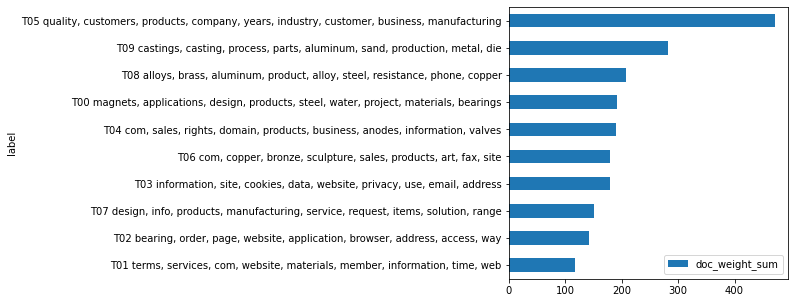

In [30]:
TOPICS.sort_values('doc_weight_sum', ascending=True).plot.barh(y='doc_weight_sum', x='label', figsize=(5, n_topics/2));

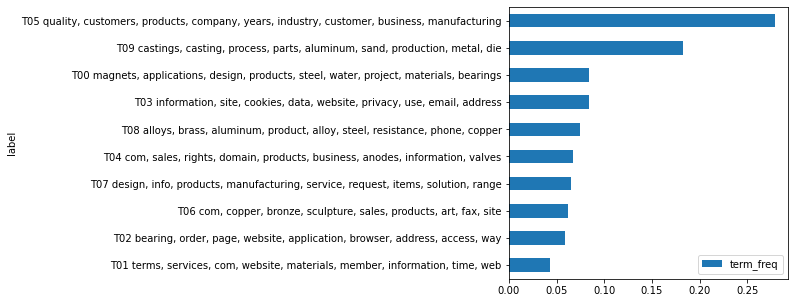

In [31]:
TOPICS.sort_values('term_freq', ascending=True).plot.barh(y='term_freq', x='label', figsize=(5,n_topics/2));

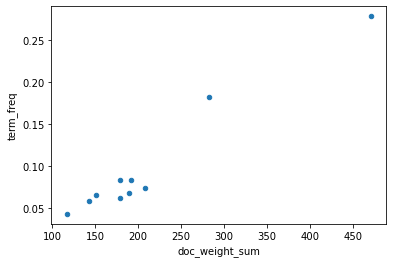

In [32]:
TOPICS.plot.scatter('doc_weight_sum', 'term_freq');

In [31]:
LIB = pd.read_csv('LIB.csv').rename(columns={'company_num':'company_id'})#.set_index('company_id')
LIB

,company_id,total_words,total_links
0,1,2796,26
1,5,368,9
2,10,845,11
3,12,1194,7
4,14,682,3
...,...,...,...
295,1211,968,7
296,1212,372,3
297,1216,1948,9
298,1219,2084,12
